In [1]:
import random
import pandas as pd
import numpy as np
import os
import IPython.display as ipd
from tqdm.auto import tqdm
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn, optim
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import time

In [2]:
from collections import defaultdict
from torchsummary import summary
from datetime import timedelta

In [3]:
import warnings
warnings.filterwarnings(action='ignore') 

# 파일 unzip

In [4]:
# import zipfile
 
# try:
#     with zipfile.ZipFile("C:/Users/User/Downloads/open.zip") as zf:
#         zf.extractall()
#         print("uncompress success")
# except:
#     print("uncompress fail")

uncompress success


In [5]:
train_df = pd.read_csv('./train.csv') # 모두 정상 Sample
test_df = pd.read_csv('./test.csv')

In [9]:
#print(train_df.shape)
#train_df.head()

In [7]:
train_df['FAN_TYPE'].value_counts()

2    640
0    639
Name: FAN_TYPE, dtype: int64

In [8]:
train_df['LABEL'].value_counts()

0    1279
Name: LABEL, dtype: int64

In [10]:
#print(test_df.shape)
#test_df.head()

In [10]:
test_df['FAN_TYPE'].value_counts()

0    779
2    735
Name: FAN_TYPE, dtype: int64

# Listen train/test sample

In [11]:
def listen_file(df, sample_num):
    cond_fan_0 = (df['FAN_TYPE'] == 0)
    fan_0 = df.loc[cond_fan_0]
    fan_2 = df.loc[~cond_fan_0]
    print('\nFan Type : 0\n')
    list_sample_path = list(fan_0.sample(sample_num, random_state=1)['SAMPLE_PATH'])

    for i in range(len(list_sample_path)):
        path = list_sample_path[i]
        file_name = path.split('/')[-1]
        print('\n'+file_name+'\n')
        display(ipd.Audio(path))
        print('\nFan Type : 2\n')
        list_sample_path = list(fan_2.sample(sample_num, random_state=1)['SAMPLE_PATH'])

    for i in range(len(list_sample_path)):
        path = list_sample_path[i]
        file_name = path.split('/')[-1]
        print('\n'+file_name+'\n')
        display(ipd.Audio(path))

In [11]:
#listen_file(train_df, 2)

In [1]:
#listen_file(test_df, 2)

# EDA

# Sampling Rate(SR) -> 아날로그 신호를 디지털(숫자)로 변환 시킨 것

In [14]:
def check_sr(df):
    list_sr = []

    for path in tqdm(train_df['SAMPLE_PATH']):
        # sampling rate (sr) : 초당 샘플 갯수
        sampling_rate = librosa.get_samplerate(path)
        list_sr.append(sampling_rate)

    return list_sr

In [15]:
list_train_sr = check_sr(train_df)
list_test_sr = check_sr(test_df)

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Test Data SR')

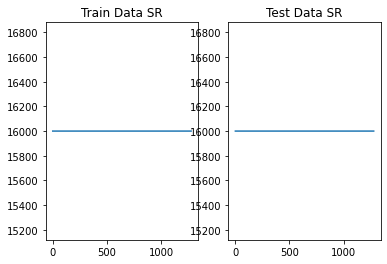

In [16]:
plt.subplot(1, 2, 1)
plt.plot(list_train_sr)
plt.title('Train Data SR')

plt.subplot(1, 2, 2)
fig2 = plt.plot(list_test_sr)
plt.title('Test Data SR')

# Waveform 시각화

In [17]:
def check_waveform(df, sample_num):
    cond_fan_0 = (df['FAN_TYPE'] == 0)
    fan_0 = df.loc[cond_fan_0]
    fan_2 = df.loc[~cond_fan_0]
    print('\nFan Type : 0\n')
    list_sample_path = list(fan_0.sample(sample_num, random_state=303)['SAMPLE_PATH'])
    for path in list_sample_path:
        wav, sr = librosa.load(path, sr=16000)
        fig = plt.figure(figsize = (14,5))
        librosa.display.waveshow(wav, sr=sr)
        plt.title(path.split('/')[-1])
        plt.ylabel("Amplitude")
        plt.show()

    print('\nFan Type : 2\n')
    list_sample_path = list(fan_2.sample(sample_num, random_state=303)['SAMPLE_PATH'])
    for path in list_sample_path:
        wav, sr = librosa.load(path, sr=16000)
        fig = plt.figure(figsize = (14,5))
        librosa.display.waveshow(wav, sr=sr)
        plt.title(path.split('/')[-1])
        plt.ylabel("Amplitude")
        plt.show()

In [18]:
data, sr = librosa.load('./train/TRAIN_0056.wav', sr=16000)
print('sample_rate:', sr, ', audio shape:', data.shape)
print('length:', data.shape[0]/float(sr), 'secs')

sample_rate: 16000 , audio shape: (160000,)
length: 10.0 secs



Fan Type : 0



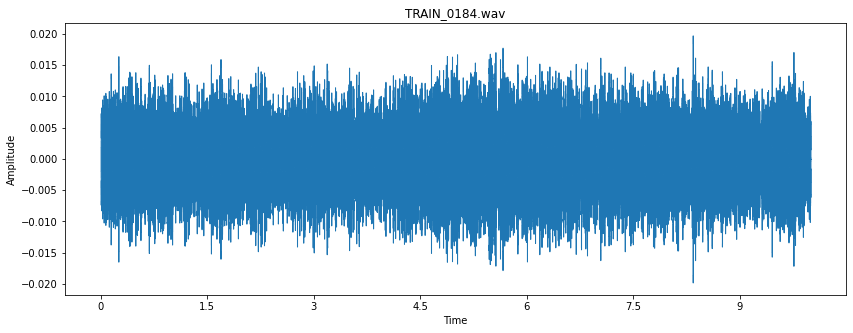


Fan Type : 2



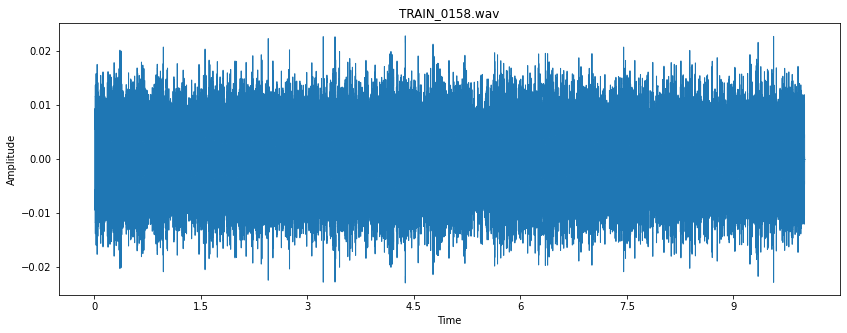

In [19]:
check_waveform(train_df, 1)

In [2]:
#check_waveform(test_df, 1)

# MFCC

In [21]:
def check_MFCC(df, sample_num, n_fft, hop_length, n_mfcc): 

    cond_fan_0 = (df['FAN_TYPE'] == 0)

    fan_0 = df.loc[cond_fan_0]

    fan_2 = df.loc[~cond_fan_0]

    print('\nFan Type : 0\n')

    list_sample_path = list(fan_0.sample(sample_num, random_state=303)['SAMPLE_PATH'])

    for path in list_sample_path:

        wav, sr = librosa.load(path, sr=16000)

        MFCCs = librosa.feature.mfcc(wav, 
                                 sr = sr,
                                 n_fft = n_fft,
                                 hop_length = hop_length,
                                 n_mfcc = n_mfcc) 

        fig = plt.figure(figsize = (14,5))
        librosa.display.specshow(MFCCs, 
                                sr=sr, 
                                hop_length=hop_length,
                                x_axis='time',)
        plt.title(path.split('/')[-1])
        plt.xlabel("Time")
        plt.ylabel("Frequency")
        plt.colorbar(format='%+2.0f dB')
        plt.show()

    print('\nFan Type : 2\n')

    list_sample_path = list(fan_2.sample(sample_num, random_state=303)['SAMPLE_PATH'])

    for path in list_sample_path:

        wav, sr = librosa.load(path, sr=16000)

        MFCCs = librosa.feature.mfcc(wav, 
                                 sr = sr,
                                 n_fft = n_fft,
                                 hop_length = hop_length,
                                 n_mfcc = n_mfcc) 

        fig = plt.figure(figsize = (14,5))
        librosa.display.specshow(MFCCs, 
                                sr=sr, 
                                hop_length=hop_length,
                                x_axis='time',)
        plt.title(path.split('/')[-1])
        plt.xlabel("Time")
        plt.ylabel("Frequency")
        plt.colorbar(format='%+2.0f dB')
        plt.show()


Fan Type : 0



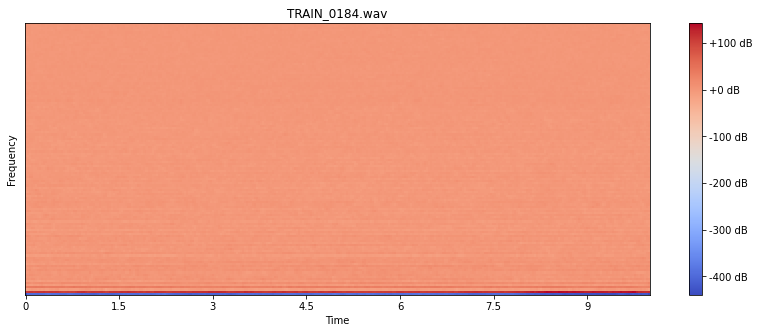


Fan Type : 2



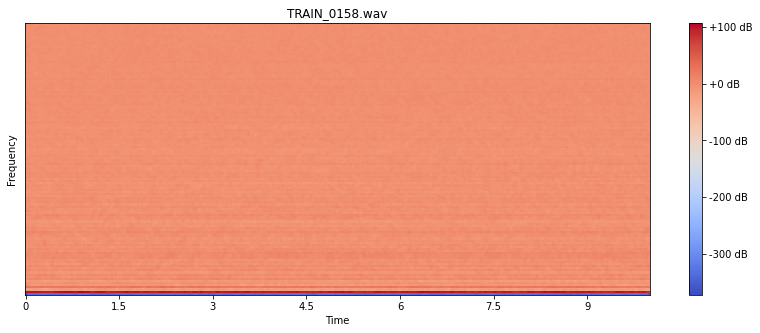

In [22]:
check_MFCC(train_df, 1, 2048, 512, 128)

# data preprocessing

## wav 추출 및 데이터 정제

In [23]:
def train_wavdataset():
    folder = "./train"
    dataset = []
    for file in tqdm(os.listdir(folder),colour='green'):
        if 'wav' in file:
            abs_file_path = os.path.join(folder,file)
            print(abs_file_path)
            data, sr = librosa.load(abs_file_path, sr = 16000)
            dataset.append(data)
    print("Dataset 생성 완료")
    return dataset

In [12]:
# a = train_wavdataset()
# train_df['data'] = a

In [8]:
# 현재 train_df에는 wav data를 가지고 있음!
#train_df

In [26]:
def test_wavdataset():
    folder = "./test"
    dataset = []
    for file in tqdm(os.listdir(folder),colour='green'):
        if 'wav' in file:
            abs_file_path = os.path.join(folder,file)
            print(abs_file_path)
            data, sr = librosa.load(abs_file_path, sr = 16000)
            dataset.append(data)
    print("Dataset 생성 완료")
    return dataset

In [7]:
#b = test_wavdataset()
#test_df['data'] = b

In [6]:
#test_df

## wav 값을 mfcc값으로 변환하기

### train data 정리

In [29]:
df_train = train_df.copy()

In [30]:
def preprocess_dataset(data):
    mfccs = []
    for i in data:
        extracted_features = librosa.feature.mfcc(y=i,
                                              sr=16000,
                                              n_mfcc=128)
        print(extracted_features.shape)
        extracted_features = np.mean(extracted_features.T,axis=0)
        mfccs.append(extracted_features)
            
    return mfccs

train_mfccs = preprocess_dataset(df_train.data)
train_mfccs  = np.array(train_mfccs)

(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)

(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)

In [31]:
# 현재 상황 : librosa.feature.mfcc를 통해서 wav파일 하나당 (123,313)크기의 특징이 추출되었음!
# wav 파일 하나의 행에 313개의 열이 존재한다는 뜻
# 이를 mean하여 추출된 mfcc값을 wav당 128개의 값을 가진 1차원 array로 만들었음!

In [32]:
print("wavfile의 수 확인 : ", len(train_mfccs))
print("mfcc shape 확인 :", train_mfccs.shape)

wavfile의 수 확인 :  1279
mfcc shape 확인 : (1279, 128)


### test data 정리

In [33]:
df_test = test_df.copy()

In [5]:
#df_test

In [35]:
a = preprocess_dataset(df_test.data)
test_mfccs  = np.array(a)

(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)

(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)
(128, 313)

(128, 313)
(128, 313)
(128, 313)
(128, 313)


In [36]:
df_test['mfcc'] = a

In [4]:
#df_test

In [38]:
print("wavfile의 수 확인 : ", len(test_mfccs))
print("mfcc shape 확인 :", test_mfccs.shape)

wavfile의 수 확인 :  1514
mfcc shape 확인 : (1514, 128)


# model 만들기

In [39]:
# 오토인코더 모듈 정의
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential( # nn.Sequential을 사용해 encoder와 decoder 두 모듈로 묶어줍니다.
            nn.Linear(128, 64), 
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(32, 16),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(32, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        encode = self.encoder(x) 
        decode = self.decoder(encode)
        return decode

# model에 관한 설정

In [40]:
# 하이퍼파라미터 준비
num_epochs = 100
BATCH_SIZE = 32
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", device)

Using Device: cuda


In [41]:
train = torch.utils.data.DataLoader(
            train_mfccs,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=20
        )

In [42]:
autoencoder = Autoencoder().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.01) 
criterion = nn.MSELoss()

In [43]:
# loss 값 저장
metrics = defaultdict(list)

In [44]:
summary(autoencoder, (1, 128),batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [32, 1, 64]           8,256
         LeakyReLU-2                [32, 1, 64]               0
            Linear-3                [32, 1, 32]           2,080
         LeakyReLU-4                [32, 1, 32]               0
            Linear-5                [32, 1, 16]             528
         LeakyReLU-6                [32, 1, 16]               0
            Linear-7                [32, 1, 32]             544
         LeakyReLU-8                [32, 1, 32]               0
            Linear-9                [32, 1, 64]           2,112
        LeakyReLU-10                [32, 1, 64]               0
           Linear-11               [32, 1, 128]           8,320
        LeakyReLU-12               [32, 1, 128]               0
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
---------------------------------

In [45]:
train_mfccs.shape

(1279, 128)

In [46]:
x = torch.randn(32,1,128,device=device)
model = Autoencoder().to(device)
out = model(x)
print(out.shape)

torch.Size([32, 1, 128])


# 모델 학습

In [45]:
autoencoder.train()
start = time.time()
for epoch in range(num_epochs):
    ep_start = time.time()
    running_loss = 0.0
    for data in train:
        generated = autoencoder(data.to(device))
        loss = criterion(data.to(device), generated)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss/len(train_mfccs)
    metrics['train_loss'].append(epoch_loss)
    ep_end = time.time()
    print('-----------------------------------------------')
    print('[EPOCH] {}/{}\n[LOSS] {}'.format(epoch+1,num_epochs, epoch_loss))
    print('Epoch Complete in {}'.format(timedelta(seconds=ep_end-ep_start)))
end = time.time()
print('-----------------------------------------------')
print('[System Complete: {}]'.format(timedelta(seconds=end-start)))

-----------------------------------------------
[EPOCH] 1/100
[LOSS] 14.520928353793552
Epoch Complete in 0:00:14.355997
-----------------------------------------------
[EPOCH] 2/100
[LOSS] 0.3753880380745322
Epoch Complete in 0:00:14.324782
-----------------------------------------------
[EPOCH] 3/100
[LOSS] 0.1804949415205418
Epoch Complete in 0:00:14.434164
-----------------------------------------------
[EPOCH] 4/100
[LOSS] 0.18111933386819823
Epoch Complete in 0:00:14.590342
-----------------------------------------------
[EPOCH] 5/100
[LOSS] 0.18965288435135902
Epoch Complete in 0:00:14.480995
-----------------------------------------------
[EPOCH] 6/100
[LOSS] 0.18884833442503068
Epoch Complete in 0:00:14.340403
-----------------------------------------------
[EPOCH] 7/100
[LOSS] 0.177268100959235
Epoch Complete in 0:00:14.496615
-----------------------------------------------
[EPOCH] 8/100
[LOSS] 0.1319234484895493
Epoch Complete in 0:00:14.480995
------------------------------

-----------------------------------------------
[EPOCH] 68/100
[LOSS] 0.05111946958969868
Epoch Complete in 0:00:14.402888
-----------------------------------------------
[EPOCH] 69/100
[LOSS] 0.048978792400076764
Epoch Complete in 0:00:14.496620
-----------------------------------------------
[EPOCH] 70/100
[LOSS] 0.044330296477272324
Epoch Complete in 0:00:14.340397
-----------------------------------------------
[EPOCH] 71/100
[LOSS] 0.04648451930009545
Epoch Complete in 0:00:14.418509
-----------------------------------------------
[EPOCH] 72/100
[LOSS] 0.0483231837158561
Epoch Complete in 0:00:14.434132
-----------------------------------------------
[EPOCH] 73/100
[LOSS] 0.05061857452422404
Epoch Complete in 0:00:14.246673
-----------------------------------------------
[EPOCH] 74/100
[LOSS] 0.05782264457073316
Epoch Complete in 0:00:14.356056
-----------------------------------------------
[EPOCH] 75/100
[LOSS] 0.05878503109161699
Epoch Complete in 0:00:14.262295
---------------

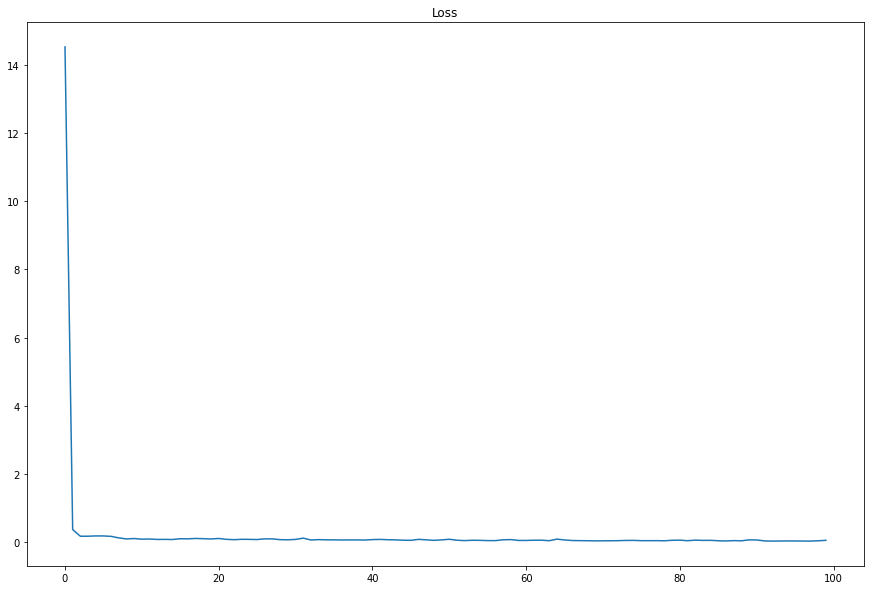

In [46]:
_, ax = plt.subplots(1,1,figsize=(15,10))
ax.set_title('Loss')
ax.plot(metrics['train_loss'])

In [ ]:
# model 가중치 저장
path2models = './models/'
os.makedirs(path2models, exist_ok=True)
path2weights = os.path.join(path2models,'AE_leakyrelu')
#torch.save(autoencoder.state_dict(), path2weights)

In [ ]:
# 가중치 불러오기
weights = torch.load(path2weights)
autoencoder.load_state_dict(weights)

# Prediction

In [47]:
test = torch.utils.data.DataLoader(
            df_test['mfcc'],
            batch_size=1,
            shuffle= False,
            num_workers=20
        )

In [48]:
model.eval()
loss_dist = []
#for bx, data in enumerate(test_):
for data in test:
    sample = model(data.to(device))
    loss = criterion(data.to(device), sample.to(device))
    loss_dist.append(loss.item())

In [49]:
min(loss_dist)

854.7142333984375

In [50]:
max(loss_dist)

2055.3388671875

In [51]:
len(loss_dist)

1514

In [52]:
df_test['mse'] = loss_dist

In [3]:
#df_test

# 시각화를 통한 threshold 확인!

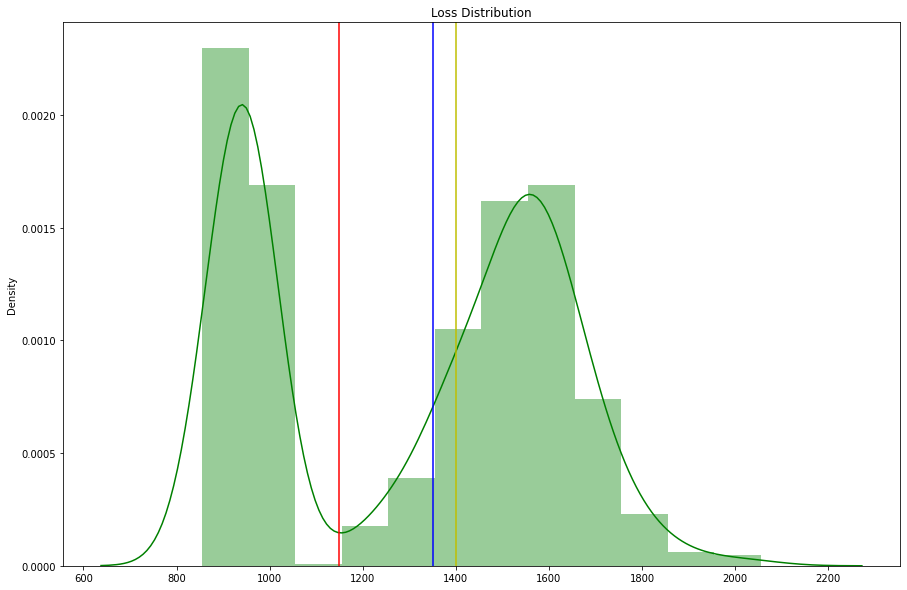

In [54]:
threshold1= 1150
threshold2= 1350
threshold3 = 1400
plt.figure(figsize=(15,10))
plt.title('Loss Distribution')
sns.distplot(loss_dist,kde=True, color='green')
plt.axvline(threshold1, 0.0, 10, color='r')
plt.axvline(threshold2, 0.0, 10, color='b')
plt.axvline(threshold3, 0.0, 10, color='y')

In [68]:
label = []

In [69]:
for i in range(len(df_test)):
    if df_test['mse'][i] > 15500:
        # 비정상
        label.append(0)
    else:
        # 정상
        label.append(1)

In [70]:
len(label)

1514

# 결과 정리

In [71]:
submit = pd.read_csv('./sample_submission.csv')

In [72]:
submit['LABEL'] = label
submit.head()

,SAMPLE_ID,LABEL
0,TEST_0000,1
1,TEST_0001,1
2,TEST_0002,1
3,TEST_0003,0
4,TEST_0004,1


In [73]:
submit.to_csv('./submit6.csv', index=False)